# Instructions

### Step 0
Before starting, we need the following:

* a shapefile containing the training labels for the area of interest
* python installation with the dependencies in step 2

### Step 1
Run the following earth engine script in Google Earth Engine and download the images and tables from Google Drive

In this example we export the data from both year 2014 and 2015. Rename the folders from the first export or change the output folder in the script so they are downloaded into separate folders. It is also necessary to copy the coordinates of the selected area in earth engine and convert it to WKT format. Example:

### Step 2
The scripts for input data processing are placed under scripts/ folder. The lastest scripts used here are read_land_use_no_gdal.py and read_image_data_scaleable.py. Import them to use in a data processing script. They depend on the following modules:
* numpy
* pandas
* rasterio
* shapely
* fiona

In [1]:
import sys
import numpy as np
import pandas as pd
import shelve
import scripts.read_land_use_no_gdal as rlu
import scripts.read_image_data_scaleable as rid

Matplotlib is not necessary and is only for visualisation.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Step 3
Define the area of interest and generate a label map of the area.

In [3]:
polygon = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869, 143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978, 143.32317350376297 -37.496296386368165))"

Use read_land_use() to generate a label map and a dict of classes. We will have to fill in the resolution of downloaded images (they should have the same resolution). The x and y here are inverted compared to the matrix representation.

In [4]:
array, classes = rlu.read_land_use(da_shapefile="SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp",
                  resolution=(1022, 973),  # 1022 in width and 973 in height
                  area_filter=polygon,
                  buffer=-0.0001,
                  processes=8)

### Step 4
Use old_data_preprocess_workflow() to generate the training set:

In [5]:
train = rid.old_data_preprocess_workflow(image_dir='area1/2014/images/',
                                         mask_dir='area1/2014/masks/', 
                                         table_dir='area1/2014/tables/LC8_SR.csv', 
                                         new_table_dir='area1/2015/tables/LC8_SR.csv', 
                                         shelve_root_dir='models/area1/shelves/', 
                                         labels=array, 
                                         processes=8, 
                                         max_days_apart=30, 
                                         step=250000)

reading data...
reading new timestamps...
interpolating images...
generating sets...


The training set is separated into several parts. Here is an exmaple of the fortmat of the set:

In [6]:
train['0'][1].head()

,1394669354132_0,1394669354132_1,1394669354132_2,1395274523472_0,1395274523472_1,1395274523472_2,1396051746370_0,1396051746370_1,1396051746370_2,1396653311630_0,...,1420934982577_0,1420934982577_1,1420934982577_2,1421540154238_0,1421540154238_1,1421540154238_2,1422317382683_0,1422317382683_1,1422317382683_2,label
0,-9999,-9999,-9999,-9999,-9999,-9999,3683,300,520,3683,...,2382,1006,739,2382,1006,739,2382,1006,739,2
1,-9999,-9999,-9999,-9999,-9999,-9999,3683,300,520,3683,...,2382,1006,739,2382,1006,739,2382,1006,739,2
2,-9999,-9999,-9999,-9999,-9999,-9999,3438,349,552,3438,...,2360,983,788,2360,983,788,2360,983,788,2
3,-9999,-9999,-9999,-9999,-9999,-9999,3089,429,564,3089,...,2290,982,780,2290,982,780,2290,982,780,2
4,-9999,-9999,-9999,-9999,-9999,-9999,2897,473,564,2897,...,2158,937,726,2158,937,726,2158,937,726,2


### Step 5
Use new_data_preprocess_workflow() to generate the prediction set:

In [7]:
to_predict = rid.new_data_preprocess_workflow(image_dir='area1/2015/images/',
                                         mask_dir='area1/2015/masks/', 
                                         table_dir='area1/2015/tables/LC8_SR.csv', 
                                         shelve_root_dir='models/area1/shelves/', 
                                         processes=8, 
                                         max_days_apart=30, 
                                         step=250000)

reading data...
reading new timestamps...
interpolating images...
generating sets...


A slice of the prediction set:

In [8]:
to_predict['0'][1].head()

,1426205354132_0,1426205354132_1,1426205354132_2,1426810523472_0,1426810523472_1,1426810523472_2,1427587746370_0,1427587746370_1,1427587746370_2,1428192911630_0,...,1451693755106_2,1452470982577_0,1452470982577_1,1452470982577_2,1453076154238_0,1453076154238_1,1453076154238_2,1453853382683_0,1453853382683_1,1453853382683_2
0,2844,1227,881,2453,1041,765,2844,1227,881,2844,...,816,2478,1211,856,1737,781,609,1737,781,609
1,2844,1227,881,2453,1041,765,2844,1227,881,2844,...,1020,2484,1306,945,1737,781,609,1737,781,609
2,2669,1336,973,2503,1261,909,2669,1336,973,2669,...,1035,2396,1376,1009,2294,1258,944,2294,1258,944
3,2601,1327,968,2466,1296,936,2601,1327,968,2601,...,1037,2382,1376,1014,2278,1303,987,2278,1303,987
4,2270,1139,820,1988,1021,727,2270,1139,820,2270,...,960,2279,1280,933,1943,1090,823,1943,1090,823


### Step 6
To access the training and prediction set after preprocessing, load the corresponding Shelf files:

In [9]:
# close the shelves first
train.close()
to_predict.close()

In [10]:
train = shelve.open('models/area1/shelves/trains')
to_predict = shelve.open('models/area1/shelves/to_predict')

Example: reconstructing the whole training set

In [11]:
full_train = pd.concat([s[1] for s in train.values()], axis=0)  # order does not matter here

In [12]:
full_train.shape

(994406, 121)

In [13]:
full_predict = pd.concat([s[1] for s in to_predict.values()], axis=0)

In [14]:
full_predict.shape

(994406, 120)

### Training and predicting example

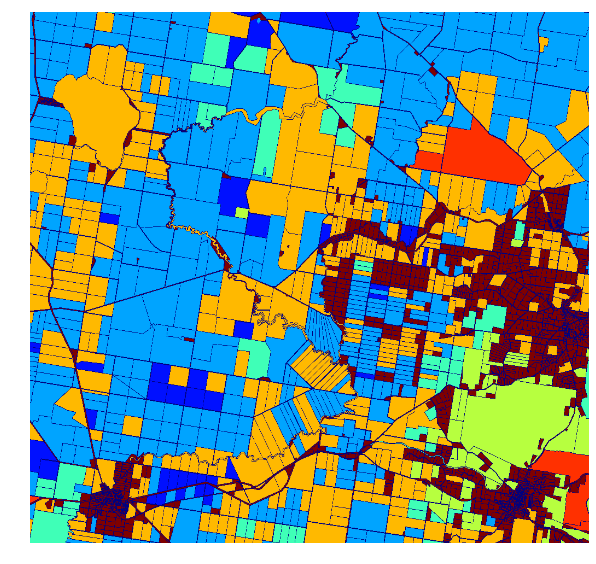

In [15]:
# label data
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(array)

In [16]:
import xgboost as xgb

/home/mithrillion/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X = full_train.ix[~np.in1d(full_train.ix[:, 'label'], [0]), :-1]
y = full_train.ix[~np.in1d(full_train.ix[:, 'label'], [0]), 'label']

In [36]:
param = {'max_depth':10, 'eta':0.2, 'objective':'multi:softmax', 'num_class': len(np.unique(y)), 
         'min_child_weight': 50}
num_round = 10

In [37]:
classes

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Hardwood plantation',
 4: 'Native woody cover',
 5: 'Pasture and grassland',
 6: 'Softwood Plantation',
 7: 'Unknown'}

In [38]:
dtrain = xgb.DMatrix(X, label=y-1, missing = -9999)

In [39]:
model = xgb.train(param, dtrain, num_round)

In [41]:
pred_new = model.predict(xgb.DMatrix(full_predict, feature_names=[str(n) for n in X.columns]))

In [42]:
cls_table = pd.DataFrame(rid.generate_coordinate_columns(973, 1022), columns=['x', 'y'])
cls_table['pred_label'] = pred_new + 1
cls_map = cls_table.pivot(index='x', columns='y', values='pred_label')

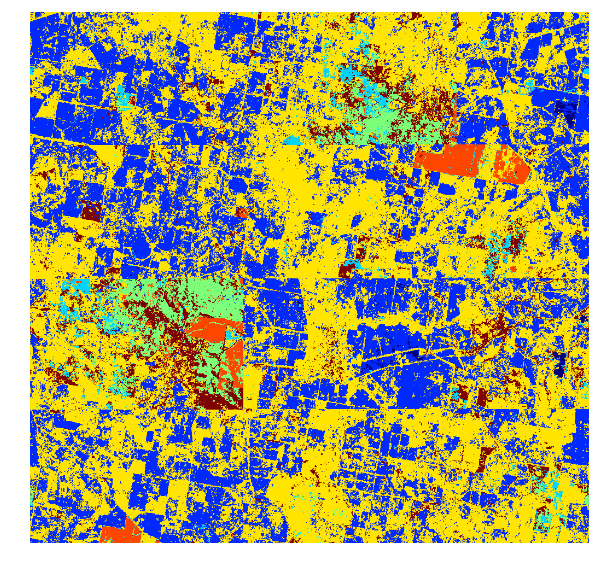

In [44]:
# prediction
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cls_map)